In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import statsmodels.api as sm

In [22]:
# Load and preprocess the dataset
df = pd.read_csv('uber.csv')
df.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)
df.fillna(method='ffill', inplace=True)
df.drop(df[df['fare_amount'] <= 0].index, inplace=True)
df.drop(df[df['passenger_count'] > 10].index, inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df.dropna(inplace=True)


C:\Users\Abhishek Kumar\AppData\Local\Temp\ipykernel_14452\4197760519.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


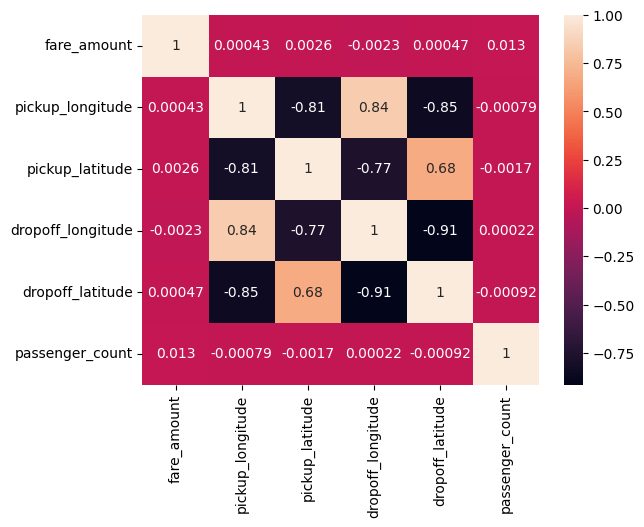

In [23]:
# Detect and handle outliers
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['fare_amount'] >= (Q1 - 1.5 * IQR)) & (df['fare_amount'] <= (Q3 + 1.5 * IQR))]

# Correlation matrix
df_for_corr = df.drop(columns=['pickup_datetime'])
sns.heatmap(df_for_corr.corr(), annot=True)
plt.show()

In [24]:
# Define features and target
X = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']]
y = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a dictionary to store model results
results = {}

In [25]:
# Define and evaluate models
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
# Linear Regression
evaluate_model('Linear Regression', LinearRegression())

In [26]:
# Random Forest Regressor
evaluate_model('Random Forest', RandomForestRegressor())

In [27]:
# XGBRegressor
evaluate_model('XGB Regressor', xgb.XGBRegressor())

In [28]:
# Elastic Net Regression
evaluate_model('Elastic Net', ElasticNet())


In [29]:
from sklearn.preprocessing import StandardScaler
# Scale data for Poisson Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Poisson Regression with positive target values
poisson_model = sm.GLM(y_train, X_train_scaled, family=sm.families.Poisson()).fit()
y_pred_poisson = poisson_model.predict(X_test_scaled)

# Store Poisson regression results
results['Poisson Regression'] = {
    'R2': r2_score(y_test, y_pred_poisson),
    'MSE': mean_squared_error(y_test, y_pred_poisson),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_poisson))
}

In [30]:
# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                          R2        MSE      RMSE
Linear Regression   0.000156  17.347739  4.165062
Random Forest       0.707515   5.074741  2.252719
XGB Regressor       0.703912   5.137250  2.266550
Elastic Net        -0.000061  17.351497  4.165513
Poisson Regression -3.656644  80.794857  8.988596


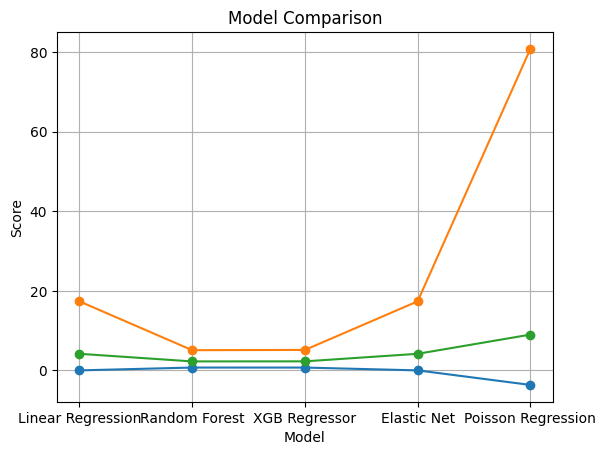

In [32]:
# Plot comparison of R2, MSE, RMSE

for metric in ['R2', 'MSE', 'RMSE']:
    plt.plot(results_df.index, results_df[metric], label=metric, marker='o')
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.grid(True)
plt.show()